# install library

In [ ]:
import os

if os.environ.get("KAGGLE_KERNEL_RUN_TYPE") is None:
    ON_KAGGLE = False
else:
    ON_KAGGLE = True
if not ON_KAGGLE:
    import shutil
    from requests import get

    from google.colab import drive, files
    # mount Google Drive
    drive.mount("/content/drive")
else:
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

Mounted at /content/drive


In [ ]:
if not ON_KAGGLE: 
    !pip uninstall -y kaggle
    !pip install kaggle
    !mkdir /root/.kaggle
    !cp /content/drive/MyDrive/kaggla-za/kaggle.json /root/.kaggle
    !kaggle datasets download -d  kozodoi/timm-pytorch-image-models
    !mkdir -p ../input/timm-pytorch-image-models
    !unzip -n -qq timm-pytorch-image-models.zip -d ../input/timm-pytorch-image-models

    #一回のみ
    # !kaggle datasets download -d kalfirst/animal-imbalance-classification-round2
    # !mkdir -p ../content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/data/animal-imbalance-classification-round2
    # !unzip -n -qq animal-imbalance-classification-round2.zip -d ../content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/data/animal-imbalance-classification-round2

    !kaggle datasets download -d kalfirst/animal-imbalance-classification-round2
    !mkdir -p ../input/animal-imbalance-classification-round2
    !unzip -n -qq animal-imbalance-classification-round2.zip -d ../input/animal-imbalance-classification-round2


Found existing installation: kaggle 1.5.12
Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
     |████████████████████████████████| 58 kB 6.8 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=33d401f36f84c6768b5cf66a26919c241d2a2438726b5081da99f403a22b9f59
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
 63% 9.00M/14.3M [00:00<00:00, 14.0MB/s]
100% 14.3M/14.3M [00:00<00:00, 21.6MB/s]
 98% 115M/117M [00:02<00:00, 55.5MB/s] 
100% 117M/117M [00:02<00:00, 43.6MB/s]


In [1]:
import sys
sys.path.append("../input/timm-pytorch-image-models/pytorch-image-models-master")

if not ON_KAGGLE:
    !pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

import gc
import math
import os
import pickle
import random
import re
import time
import warnings
from contextlib import contextmanager

from pathlib import Path
from PIL import Image

#import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import torch
import torch.nn as nn
import torch.nn.functional as F


#from albumentations.pytorch import ToTensorV2
from scipy.special import softmax
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch.optim import SGD, Adam, AdamW, RAdam
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

import timm
warnings.filterwarnings('ignore')

NameError: ignored

# Config


In [ ]:
class Config:
    Version = "exp18" # model save時のversion
    #MODEL_NAME = "resnet34" # モデル名
    #MODEL_NAME = "efficientnet_b0" # モデル名
    #MODEL_NAME = "efficientnet_b1" # モデル名
    #MODEL_NAME = "efficientnet_b2" # モデル名
    #MODEL_NAME = "efficientnet_b3" # モデル名
    #MODEL_NAME = "efficientnet_b4" # モデル名
    #MODEL_NAME = "efficientnet_b5" # モデル名
    #MODEL_NAME = "efficientnet_b6" # モデル名
    #MODEL_NAME = "efficientnet_b7" # モデル名
    #MODEL_NAME = "tf_efficientnet_b0_ns" # モデル名
    MODEL_NAME = "tf_efficientnet_b1_ns" # モデル名
    #MODEL_NAME = "resnet50" # モデル名
    # MODEL_NAME = "swin_large_patch4_window7_224"
    # MODEL_NAME = "swin_base_patch4_window7_224"
    #MODEL_NAME = "swin_small_patch4_window7_224"
    # MODEL_NAME = "swin_large_patch4_window12_384"
    # MODEL_NAME = "swin_base_patch4_window12_384"


    if ON_KAGGLE:
        # if MODEL_NAME == 'resnet34':
        #     model_name = '../input/pt-longformer-base' # https://www.kaggle.com/kishalmandal/pt-longformer-base
        # elif MODEL_NAME == 'roberta-base':
        #     model_name = '../input/roberta-base' #https://www.kaggle.com/abhishek/roberta-base
        # elif modeMODEL_NAMEl_savename == 'roberta-large':
        #     model_name = '../input/robertalarge' # https://www.kaggle.com/marshal02/robertalarge
        # elif MODEL_NAME == 'longformer-large':
        #     model_name = '../input/longformerlarge4096' # https://www.kaggle.com/hengzheng/longformerlarge4096 
        #base_dir = '/content/drive/MyDrive/petfinder'
        #data_dir = '../input/digit-recognizer/' # = DATA_PATH
        data_dir = '../input/animal-imbalance-classification-round2' # = DATA_PATH
        pre_data_dir = './preprocessed/'
        model_dir = '.'
        output_dir = '.'   
    else:
        # customize for my own Google Colab Environment
        # if model_savename == 'longformer':
        #     model_name = 'allenai/longformer-base-4096'
        # elif model_savename == 'roberta-base':
        #     model_name = 'roberta-base'
        base_dir = '/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance'
        data_dir = '../input/animal-imbalance-classification-round2' #os.path.join(base_dir, '../input/animal-imbalance-classification-round2')
        #pre_data_dir = os.path.join(base_dir, 'data/preprocessed')
        model_dir = os.path.join(base_dir, f'model/{Version}')
        output_dir = os.path.join(base_dir, f'output/{Version}')    

    is_debug = False
    if MODEL_NAME == 'resnet34':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'roberta-base':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'resnet50':
        size = 64 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'swin_large_patch4_window7_224':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'swin_base_patch4_window7_224':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'swin_small_patch4_window7_224':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'swin_large_patch4_window12_384':
        size = 384 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'swin_base_patch4_window12_384':
        size = 384 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b0':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b1':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b2':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b3':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b4':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b5':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b6':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b7':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'tf_efficientnet_b0_ns':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'tf_efficientnet_b1_ns':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    seed = 42 # seed値
    fold = 0
    num_workers = 4  #並列実行する数 was 0
    batch_size =  64 #バッチサイズ was 64 >100
    epochs = 50 #エポック数 10?
    #size = 224 # リサイズした後の画像のサイズ
    #model_lr = 1e-5 # 学習率
    T_max = 10 # 最大イテレーション数 was 10
    min_lr = 1e-3 # 学習率の最小値 was 1e-5
    weight_decay = 1e-6 # 学習減衰値
    max_grad_norm = 1000 # 勾配の最大ノルム
    print_freq = 1000 # 学習結果を表示する頻度
    probability = 0.6
    class_num = 10 
    norms = (0.5, 0.5)
    device = "cuda" if torch.cuda.is_available() else "cpu" # CPU of GPU


In [ ]:
if not ON_KAGGLE:
    if not os.path.exists(Config.model_dir):
        !mkdir $Config.model_dir
    if not os.path.exists(Config.output_dir):
        !mkdir $Config.output_dir

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Utils

In [ ]:
def init_logger(log_file='train.log'):
    """Output Log."""
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


def seed_torch(seed=Config.seed): # was seed=0
    """Fixed seed value."""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # added trueにすると再現性がなくなる


LOGGER = init_logger()
seed_torch(seed=Config.seed)

In [ ]:
def asMinutes(s):
    """Convert Seconds to Minutes."""
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    """Accessing and Converting Time Data."""
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

class AverageMeter(object):
    """Computes and stores the average and current value."""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Dataset

In [ ]:
class TrainDataset(Dataset):
    """Dataset used for training."""
    def __init__(self, df, transform=None):
        self.df = df
        self.image_paths = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        #修正部分
        path = self.image_paths[idx]
        image = np.array(Image.open(path))
        # image = self.df.loc[idx, "pixel0": "pixel783"].values.astype(np.uint8).reshape(28, 28) # csv to image
        # image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB) # GRAY to RGB

        if self.transform:
            augmented = self.transform(image=image) # augmentation
            image = augmented['image']

        label = self.labels[idx] # 正解ラベル
        return image, label

In [ ]:
class TestDataset(Dataset):
    """Dataset used for inference."""
    def __init__(self, df, transform=None):
        self.df = df
        self.image_paths = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        #修正部分
        path = self.image_paths[idx]
        image = np.array(Image.open(path))
        # image = self.df.loc[idx, "pixel0": "pixel783"].values.astype(np.uint8).reshape(28, 28)
        # image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image

# Data Augmentation

In [ ]:
def get_transforms(*, data, size, norms):

    if data == 'train':
        return A.Compose([
            A.Resize(Config.size, Config.size), # リサイズ
            A.Rotate(limit=10, border_mode=cv2.BORDER_REPLICATE, p=0.5),
            A.Cutout(num_holes=8, max_h_size=2, max_w_size=2, fill_value=0, p=0.5),
            A.Cutout(num_holes=8, max_h_size=1, max_w_size=1, fill_value=1, p=0.5),
            # A.VerticalFlip(p=0.5),
            # A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[norms[0], norms[0], norms[0]], std=[norms[1], norms[1], norms[1]], max_pixel_value=255.0, p=1.0), # 正規化
            ToTensorV2(), # Tensor型に変換
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(Config.size, Config.size),
            A.Normalize(mean=[norms[0], norms[0], norms[0]], std=[norms[1], norms[1], norms[1]], max_pixel_value=255.0, p=1.0),
            ToTensorV2(),
        ])

# Model

In [ ]:
# use timm model no pretrained
class BaseModel(nn.Module):
    def __init__(
        self, model_name=Config.MODEL_NAME, n_class=10, pretrained=False
    ):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained) # model load(pretrained=False: 事前学習なし)
        n_features = self.model.num_features#fc.in_features
        self.model.classifier = nn.Linear(n_features, n_class) # 出力層の次元をクラス数に変更

    def forward(self, x):
        output = self.model(x)
        return output

# train & valid function

In [ ]:
def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    model.train() # 学習モード
    start = end = time.time()
    global_step = 0

    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(Config.device) # 画像をcpuからgpuヘ
        labels = labels.to(Config.device) # 正解ラベルをcpuからgpuヘ
        batch_size = labels.size(0) 
        y_preds = model(images) # 予測ラベル
        loss = criterion(y_preds, labels) # lossの計算

        losses.update(loss.item(), batch_size) 
        loss.backward() # パラメータの勾配を計算
        
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), Config.max_grad_norm)
        optimizer.step() # モデル更新
        optimizer.zero_grad() # 勾配の初期化
        global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % Config.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   ))

        del y_preds, images, labels, batch_size
    del batch_time, data_time, model
    gc.collect()
    torch.cuda.empty_cache()
    
    return losses.avg

In [ ]:
def valid_fn(valid_loader, model, criterion):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(Config.device)
        labels = labels.to(Config.device)
        batch_size = labels.size(0)
        with torch.no_grad():
        #with torch.inference_mode(): Pytorch: ^1.9
            y_preds = model(images)
            loss = criterion(y_preds, labels)
            losses.update(loss.item(), batch_size)
            
            preds.append(y_preds.softmax(1).to("cpu").numpy().argmax(1))
            del loss
            batch_time.update(time.time() - end)
            end = time.time()
            if step % Config.print_freq == 0 or step == (len(valid_loader)-1):
                print('EVAL: [{0}/{1}] '
                    'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                    'Elapsed {remain:s} '
                    'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                    .format(
                    step, len(valid_loader), batch_time=batch_time,
                    data_time=data_time, loss=losses,
                    remain=timeSince(start, float(step+1)/len(valid_loader)),
                    ))
        del y_preds, images, labels, batch_size
    del batch_time, data_time, model
    gc.collect()
    torch.cuda.empty_cache()

    preds = np.concatenate(preds)

    return losses.avg, preds

# Dataの確認

In [ ]:
#data_dir = "../input/digit-recognizer" # ディレクトリパス = data_dir
if ON_KAGGLE:
    train = pd.read_csv(Config.data_dir + "/train.csv") # csvの読み込み
    train['image_id'] = Config.data_dir + '/train_images/' + train['image_id']
else:
    train = pd.read_csv(f'{Config.data_dir}/train.csv')
    train['image_id'] = Config.data_dir + '/train_images/' + train['image_id']

train.head()

,image_id,label
0,../input/animal-imbalance-classification-round...,0
1,../input/animal-imbalance-classification-round...,0
2,../input/animal-imbalance-classification-round...,0
3,../input/animal-imbalance-classification-round...,0
4,../input/animal-imbalance-classification-round...,0


In [ ]:
#train['image_id'][0]

In [ ]:
import plotly.express as px

target = train.label.value_counts()
#class_num = len(target)

fig = px.pie(target,
             values='label',
             names=target.index,
             hole=.4, 
             width=500, height=500)
fig.update_traces(textinfo='value+label', pull=0.01)
fig.show()

In [ ]:
fig = px.bar(target.sort_index().index, target.sort_index(), width=1000, height=400)
fig.show()

# 前処理

### ホールドアウト

In [ ]:
f0, f1 = train_test_split(train, test_size=0.2) # 学習用と評価用に分ける
train["folds"] = -1
train.loc[f0.index, "folds"] = 1
train.loc[f1.index, "folds"] = 0
train

,image_id,label,folds
0,../input/animal-imbalance-classification-round...,0,1
1,../input/animal-imbalance-classification-round...,0,1
2,../input/animal-imbalance-classification-round...,0,1
3,../input/animal-imbalance-classification-round...,0,1
4,../input/animal-imbalance-classification-round...,0,0
...,...,...,...
36495,../input/animal-imbalance-classification-round...,9,1
36496,../input/animal-imbalance-classification-round...,9,1
36497,../input/animal-imbalance-classification-round...,9,1
36498,../input/animal-imbalance-classification-round...,9,1


#### 平均と標準偏差を計算

In [ ]:
#修正部分
# images = train.loc[:, "pixel0": "pixel783"].values.astype(np.uint8).reshape(-1, 28, 28)
# norms = (np.mean(images[train.folds!=0] / 255), np.std(images[train.folds!=0] / 255)) # 平均と標準偏差を計算
# print("平均と標準偏差: ", norms)

#### 画像サイズの確認と数例を表示

In [ ]:
# norms = (0.5, 0.5)
# train_dataset = TrainDataset(train,transform=get_transforms(data='train', size=Config.size, norms=Config.norms)) # 学習用のdatasetを作成
# train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, num_workers=Config.num_workers, pin_memory=True, drop_last=True)# 学習用のdatasetsのbatchを作成
# image_iter = iter(train_loader)
# images, labels = image_iter.next()

In [ ]:
# print("height: ", images.shape[1])
# print("weight: ", images.shape[2])

# for n in range(3):
#     fig, axes = plt.subplots(1, 10, figsize=(20, 30))
#     [axes[i].imshow(images[idx]) for i, idx in enumerate(range(n*10, (n+1)*10))]

#     plt.show()

# 学習の際必要になる知識

## 評価指標(Accuracy), Confusion matrix
#### 詳細については、来週説明

## ハイパラメータの用語簡易説明など

> #### * 学習率 : 学習一回当たりの更新量のようなものです。 今回のデフォルトは1e-5です。
> #### * スケジューラー : epoch数に応じて、学習率を変化させるものです。 今回のデフォルトはCosineAnnealingLRです。
> #### * 損失関数: 正解ラベルと予測ラベルの誤差の大きさを計算する関数。 
> #### * 最適化関数: 効率よく損失を減らすための関数。 
> #### * timm : 画像のコンペでpytorchを使う場合にほぼ確実に使用するライブラリですので、見ておきましょう。[github](https://github.com/rwightman/pytorch-image-models)

# 軽めのモデル作成

### モデルの読み込み

In [ ]:
model = BaseModel(Config.MODEL_NAME, Config.class_num)
model

BaseModel(
  (model): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_runnin

### 最適化関数

In [ ]:
# Adam は勾配を移動平均と学習率の調整からなります (MomentumとRMSProp)
#optimizer = Adam(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay, amsgrad=False)
optimizer = AdamW(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay, amsgrad=False)
#optimizer = RAdam(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay)


### スケジューラ

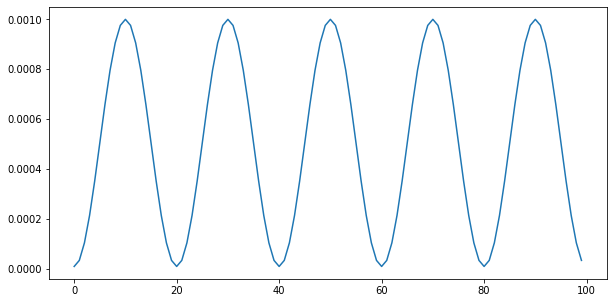

In [ ]:
scheduler = CosineAnnealingLR(optimizer, T_max=Config.T_max, eta_min=0.001)

log_s = []
for epoch in range(0, 100):
    log_s.append(scheduler.get_last_lr()[0])
    scheduler.step()

plt.figure(figsize=(10, 5))
plt.plot(np.arange(100), log_s)
plt.show()

# 学習

In [ ]:
def train_loop(train, fold, class_num=None, norms=(0.5, 0.5)):
    
    train_index = train[train['folds'] != fold].index # 学習用のindex
    valid_index = train[train['folds'] == fold].index # 評価用のindex

    train_dataset = TrainDataset(train.loc[train_index].reset_index(drop=True), 
                                 transform=get_transforms(data='train', size=Config.size, norms=norms)) # 学習用のdatasetを作成
    valid_dataset = TrainDataset(train.loc[valid_index].reset_index(drop=True), 
                                 transform=get_transforms(data='valid', size=Config.size, norms=norms)) # 評価用のdatasetを作成

    train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, 
                              num_workers=Config.num_workers, pin_memory=True, drop_last=True)# 学習用のdatasetsのbatchを作成
    valid_loader = DataLoader(valid_dataset, batch_size=Config.batch_size, shuffle=False, 
                              num_workers=Config.num_workers, pin_memory=True, drop_last=False) # 評価用のdatasetsのbatchを作成
    
    
    model = BaseModel(Config.MODEL_NAME, class_num).to(Config.device)

    #optimizer = Adam(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay, amsgrad=False)
    optimizer = AdamW(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay, amsgrad=False)
    #optimizer = RAdam(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay)

    scheduler = CosineAnnealingLR(optimizer, T_max=Config.T_max, eta_min=Config.min_lr, last_epoch=-1)

    criterion = nn.CrossEntropyLoss() # loss function

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(Config.epochs):
        start_time = time.time()
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler) # 学習
        avg_val_loss, predict = valid_fn(valid_loader, model, criterion) # 評価用の推論
        valid_labels = train.loc[valid_index, "label"].values # 予測ラベル
        
        scheduler.step() 
        score = accuracy_score(valid_labels, predict) # 適合率を計算
        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')

        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            model_filename = f'{Config.model_dir}/{Config.MODEL_NAME}_fold{fold}_best_{Config.Version}.pth'
            torch.save(model.state_dict(), model_filename) # モデルの保存
            #torch.save(model.state_dict(), "./" + f'{Config.MODEL_NAME}_fold{fold}_best_{Config.Version}.pth') # モデルの保存
            print(f'{model_filename} saved')

            valid_folds_predict = predict
            
        del avg_loss, avg_val_loss, valid_labels, predict, score
        gc.collect()
        torch.cuda.empty_cache()

    return valid_folds_predict

In [ ]:
preds = train_loop(train, fold=Config.fold, class_num=Config.class_num, norms=Config.norms)

Epoch: [1][0/456] Data 1.305 (1.305) Elapsed 0m 2s (remain 22m 10s) Loss: 2.3490(2.3490) 
Epoch: [1][455/456] Data 0.000 (0.003) Elapsed 3m 36s (remain 0m 0s) Loss: 2.1749(2.2314) 
EVAL: [0/115] Data 0.842 (0.842) Elapsed 0m 1s (remain 2m 1s) Loss: 2.1820(2.1820) 
EVAL: [114/115] Data 0.000 (0.012) Elapsed 0m 17s (remain 0m 0s) Loss: 2.8956(2.2780) 


Epoch 1 - avg_train_loss: 2.2314  avg_val_loss: 2.2780  time: 234s
Epoch 1 - Accuracy: 0.1482191780821918
Epoch 1 - Save Best Score: 0.1482 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp18/tf_efficientnet_b1_ns_fold0_best_exp18.pth saved
Epoch: [2][0/456] Data 0.674 (0.674) Elapsed 0m 1s (remain 11m 17s) Loss: 2.1609(2.1609) 
Epoch: [2][455/456] Data 0.000 (0.002) Elapsed 3m 39s (remain 0m 0s) Loss: 1.6919(1.8606) 
EVAL: [0/115] Data 0.463 (0.463) Elapsed 0m 0s (remain 1m 11s) Loss: 1.0476(1.0476) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 16s (remain 0m 0s) Loss: 3.9673(1.7910) 


Epoch 2 - avg_train_loss: 1.8606  avg_val_loss: 1.7910  time: 236s
Epoch 2 - Accuracy: 0.34657534246575344
Epoch 2 - Save Best Score: 0.3466 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp18/tf_efficientnet_b1_ns_fold0_best_exp18.pth saved
Epoch: [3][0/456] Data 0.839 (0.839) Elapsed 0m 1s (remain 12m 58s) Loss: 1.7185(1.7185) 
Epoch: [3][455/456] Data 0.000 (0.002) Elapsed 3m 40s (remain 0m 0s) Loss: 1.1503(1.5023) 
EVAL: [0/115] Data 0.661 (0.661) Elapsed 0m 0s (remain 1m 48s) Loss: 1.3529(1.3529) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 16s (remain 0m 0s) Loss: 2.6506(1.3749) 


Epoch 3 - avg_train_loss: 1.5023  avg_val_loss: 1.3749  time: 237s
Epoch 3 - Accuracy: 0.5050684931506849
Epoch 3 - Save Best Score: 0.5051 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp18/tf_efficientnet_b1_ns_fold0_best_exp18.pth saved
Epoch: [4][0/456] Data 0.867 (0.867) Elapsed 0m 1s (remain 12m 42s) Loss: 1.2569(1.2569) 
Epoch: [4][455/456] Data 0.000 (0.002) Elapsed 3m 39s (remain 0m 0s) Loss: 1.3761(1.2944) 
EVAL: [0/115] Data 0.732 (0.732) Elapsed 0m 0s (remain 1m 50s) Loss: 0.8843(0.8843) 
EVAL: [114/115] Data 0.000 (0.011) Elapsed 0m 16s (remain 0m 0s) Loss: 2.9503(1.1677) 


Epoch 4 - avg_train_loss: 1.2944  avg_val_loss: 1.1677  time: 237s
Epoch 4 - Accuracy: 0.569041095890411
Epoch 4 - Save Best Score: 0.5690 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp18/tf_efficientnet_b1_ns_fold0_best_exp18.pth saved
Epoch: [5][0/456] Data 0.981 (0.981) Elapsed 0m 1s (remain 13m 9s) Loss: 1.2831(1.2831) 
Epoch: [5][455/456] Data 0.000 (0.002) Elapsed 3m 40s (remain 0m 0s) Loss: 0.9458(1.0935) 
EVAL: [0/115] Data 0.800 (0.800) Elapsed 0m 0s (remain 1m 50s) Loss: 0.8544(0.8544) 
EVAL: [114/115] Data 0.000 (0.012) Elapsed 0m 16s (remain 0m 0s) Loss: 2.2706(0.9338) 


Epoch 5 - avg_train_loss: 1.0935  avg_val_loss: 0.9338  time: 237s
Epoch 5 - Accuracy: 0.6716438356164384
Epoch 5 - Save Best Score: 0.6716 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp18/tf_efficientnet_b1_ns_fold0_best_exp18.pth saved
Epoch: [6][0/456] Data 0.722 (0.722) Elapsed 0m 1s (remain 12m 1s) Loss: 0.8501(0.8501) 
Epoch: [6][455/456] Data 0.000 (0.002) Elapsed 3m 39s (remain 0m 0s) Loss: 0.6036(0.8952) 
EVAL: [0/115] Data 0.741 (0.741) Elapsed 0m 0s (remain 1m 45s) Loss: 0.5750(0.5750) 
EVAL: [114/115] Data 0.000 (0.011) Elapsed 0m 16s (remain 0m 0s) Loss: 1.7009(0.8187) 


Epoch 6 - avg_train_loss: 0.8952  avg_val_loss: 0.8187  time: 237s
Epoch 6 - Accuracy: 0.7176712328767123
Epoch 6 - Save Best Score: 0.7177 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp18/tf_efficientnet_b1_ns_fold0_best_exp18.pth saved
Epoch: [7][0/456] Data 0.947 (0.947) Elapsed 0m 1s (remain 12m 25s) Loss: 0.8296(0.8296) 
Epoch: [7][455/456] Data 0.000 (0.002) Elapsed 3m 39s (remain 0m 0s) Loss: 0.5715(0.7333) 
EVAL: [0/115] Data 0.711 (0.711) Elapsed 0m 0s (remain 1m 39s) Loss: 0.5889(0.5889) 
EVAL: [114/115] Data 0.000 (0.011) Elapsed 0m 16s (remain 0m 0s) Loss: 2.5656(0.6742) 


Epoch 7 - avg_train_loss: 0.7333  avg_val_loss: 0.6742  time: 237s
Epoch 7 - Accuracy: 0.7671232876712328
Epoch 7 - Save Best Score: 0.7671 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp18/tf_efficientnet_b1_ns_fold0_best_exp18.pth saved
Epoch: [8][0/456] Data 0.954 (0.954) Elapsed 0m 1s (remain 12m 26s) Loss: 0.6209(0.6209) 
Epoch: [8][455/456] Data 0.000 (0.002) Elapsed 3m 39s (remain 0m 0s) Loss: 0.5601(0.6076) 
EVAL: [0/115] Data 0.636 (0.636) Elapsed 0m 0s (remain 1m 40s) Loss: 0.5818(0.5818) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 16s (remain 0m 0s) Loss: 0.4593(0.6748) 


Epoch 8 - avg_train_loss: 0.6076  avg_val_loss: 0.6748  time: 237s
Epoch 8 - Accuracy: 0.7671232876712328


Epoch: [9][0/456] Data 0.864 (0.864) Elapsed 0m 1s (remain 12m 10s) Loss: 0.5204(0.5204) 
Epoch: [9][455/456] Data 0.000 (0.002) Elapsed 3m 40s (remain 0m 0s) Loss: 0.3819(0.5208) 
EVAL: [0/115] Data 0.683 (0.683) Elapsed 0m 0s (remain 1m 41s) Loss: 0.3825(0.3825) 
EVAL: [114/115] Data 0.000 (0.011) Elapsed 0m 16s (remain 0m 0s) Loss: 0.9853(0.6771) 


Epoch 9 - avg_train_loss: 0.5208  avg_val_loss: 0.6771  time: 237s
Epoch 9 - Accuracy: 0.7775342465753424
Epoch 9 - Save Best Score: 0.7775 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp18/tf_efficientnet_b1_ns_fold0_best_exp18.pth saved
Epoch: [10][0/456] Data 0.780 (0.780) Elapsed 0m 1s (remain 11m 56s) Loss: 0.4392(0.4392) 
Epoch: [10][455/456] Data 0.000 (0.002) Elapsed 3m 39s (remain 0m 0s) Loss: 0.2046(0.4430) 
EVAL: [0/115] Data 0.743 (0.743) Elapsed 0m 0s (remain 1m 46s) Loss: 0.4988(0.4988) 
EVAL: [114/115] Data 0.000 (0.011) Elapsed 0m 16s (remain 0m 0s) Loss: 0.3222(0.5719) 


Epoch 10 - avg_train_loss: 0.4430  avg_val_loss: 0.5719  time: 237s
Epoch 10 - Accuracy: 0.8087671232876712
Epoch 10 - Save Best Score: 0.8088 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp18/tf_efficientnet_b1_ns_fold0_best_exp18.pth saved
Epoch: [11][0/456] Data 0.957 (0.957) Elapsed 0m 1s (remain 12m 35s) Loss: 0.4141(0.4141) 
Epoch: [11][455/456] Data 0.000 (0.002) Elapsed 3m 40s (remain 0m 0s) Loss: 0.2500(0.3757) 
EVAL: [0/115] Data 0.716 (0.716) Elapsed 0m 0s (remain 1m 47s) Loss: 0.7494(0.7494) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 16s (remain 0m 0s) Loss: 0.3051(0.5950) 


Epoch 11 - avg_train_loss: 0.3757  avg_val_loss: 0.5950  time: 237s
Epoch 11 - Accuracy: 0.812054794520548
Epoch 11 - Save Best Score: 0.8121 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp18/tf_efficientnet_b1_ns_fold0_best_exp18.pth saved
Epoch: [12][0/456] Data 1.018 (1.018) Elapsed 0m 1s (remain 13m 9s) Loss: 0.2987(0.2987) 
Epoch: [12][455/456] Data 0.000 (0.003) Elapsed 3m 40s (remain 0m 0s) Loss: 0.5358(0.3049) 
EVAL: [0/115] Data 0.592 (0.592) Elapsed 0m 0s (remain 1m 28s) Loss: 0.4837(0.4837) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 16s (remain 0m 0s) Loss: 0.5489(0.5384) 


Epoch 12 - avg_train_loss: 0.3049  avg_val_loss: 0.5384  time: 237s
Epoch 12 - Accuracy: 0.8297260273972603
Epoch 12 - Save Best Score: 0.8297 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp18/tf_efficientnet_b1_ns_fold0_best_exp18.pth saved
Epoch: [13][0/456] Data 0.820 (0.820) Elapsed 0m 1s (remain 12m 35s) Loss: 0.2168(0.2168) 
Epoch: [13][455/456] Data 0.000 (0.002) Elapsed 3m 39s (remain 0m 0s) Loss: 0.1529(0.2462) 
EVAL: [0/115] Data 0.616 (0.616) Elapsed 0m 0s (remain 1m 37s) Loss: 0.3398(0.3398) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 16s (remain 0m 0s) Loss: 0.4108(0.6341) 


Epoch 13 - avg_train_loss: 0.2462  avg_val_loss: 0.6341  time: 237s
Epoch 13 - Accuracy: 0.8128767123287671


Epoch: [14][0/456] Data 0.643 (0.643) Elapsed 0m 1s (remain 11m 27s) Loss: 0.1167(0.1167) 
Epoch: [14][455/456] Data 0.000 (0.002) Elapsed 3m 40s (remain 0m 0s) Loss: 0.1739(0.1702) 
EVAL: [0/115] Data 0.577 (0.577) Elapsed 0m 0s (remain 1m 33s) Loss: 0.3036(0.3036) 
EVAL: [114/115] Data 0.000 (0.009) Elapsed 0m 16s (remain 0m 0s) Loss: 0.3891(0.5925) 


Epoch 14 - avg_train_loss: 0.1702  avg_val_loss: 0.5925  time: 237s
Epoch 14 - Accuracy: 0.8321917808219178
Epoch 14 - Save Best Score: 0.8322 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp18/tf_efficientnet_b1_ns_fold0_best_exp18.pth saved
Epoch: [15][0/456] Data 0.901 (0.901) Elapsed 0m 1s (remain 12m 48s) Loss: 0.1569(0.1569) 
Epoch: [15][455/456] Data 0.000 (0.002) Elapsed 3m 40s (remain 0m 0s) Loss: 0.1541(0.1182) 
EVAL: [0/115] Data 0.821 (0.821) Elapsed 0m 0s (remain 1m 51s) Loss: 0.2755(0.2755) 
EVAL: [114/115] Data 0.000 (0.011) Elapsed 0m 16s (remain 0m 0s) Loss: 0.9169(0.5758) 


Epoch 15 - avg_train_loss: 0.1182  avg_val_loss: 0.5758  time: 237s
Epoch 15 - Accuracy: 0.8502739726027397
Epoch 15 - Save Best Score: 0.8503 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp18/tf_efficientnet_b1_ns_fold0_best_exp18.pth saved
Epoch: [16][0/456] Data 0.906 (0.906) Elapsed 0m 1s (remain 12m 22s) Loss: 0.1573(0.1573) 
Epoch: [16][455/456] Data 0.000 (0.002) Elapsed 3m 40s (remain 0m 0s) Loss: 0.0932(0.0654) 
EVAL: [0/115] Data 0.598 (0.598) Elapsed 0m 0s (remain 1m 32s) Loss: 0.5113(0.5113) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 16s (remain 0m 0s) Loss: 0.0324(0.5810) 


Epoch 16 - avg_train_loss: 0.0654  avg_val_loss: 0.5810  time: 237s
Epoch 16 - Accuracy: 0.8553424657534247
Epoch 16 - Save Best Score: 0.8553 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp18/tf_efficientnet_b1_ns_fold0_best_exp18.pth saved
Epoch: [17][0/456] Data 0.869 (0.869) Elapsed 0m 1s (remain 12m 7s) Loss: 0.0422(0.0422) 
Epoch: [17][455/456] Data 0.000 (0.002) Elapsed 3m 40s (remain 0m 0s) Loss: 0.0170(0.0369) 
EVAL: [0/115] Data 0.689 (0.689) Elapsed 0m 0s (remain 1m 41s) Loss: 0.4106(0.4106) 
EVAL: [114/115] Data 0.000 (0.011) Elapsed 0m 16s (remain 0m 0s) Loss: 0.0413(0.5882) 


Epoch 17 - avg_train_loss: 0.0369  avg_val_loss: 0.5882  time: 237s
Epoch 17 - Accuracy: 0.8650684931506849
Epoch 17 - Save Best Score: 0.8651 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp18/tf_efficientnet_b1_ns_fold0_best_exp18.pth saved
Epoch: [18][0/456] Data 0.818 (0.818) Elapsed 0m 1s (remain 12m 36s) Loss: 0.0176(0.0176) 
Epoch: [18][455/456] Data 0.000 (0.002) Elapsed 3m 40s (remain 0m 0s) Loss: 0.0082(0.0219) 
EVAL: [0/115] Data 0.793 (0.793) Elapsed 0m 1s (remain 1m 55s) Loss: 0.3594(0.3594) 
EVAL: [114/115] Data 0.000 (0.012) Elapsed 0m 16s (remain 0m 0s) Loss: 0.2036(0.5980) 


Epoch 18 - avg_train_loss: 0.0219  avg_val_loss: 0.5980  time: 237s
Epoch 18 - Accuracy: 0.8628767123287672


Epoch: [19][0/456] Data 0.720 (0.720) Elapsed 0m 1s (remain 11m 57s) Loss: 0.0149(0.0149) 
Epoch: [19][455/456] Data 0.000 (0.002) Elapsed 3m 40s (remain 0m 0s) Loss: 0.0009(0.0125) 
EVAL: [0/115] Data 0.661 (0.661) Elapsed 0m 0s (remain 1m 39s) Loss: 0.3148(0.3148) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 16s (remain 0m 0s) Loss: 0.4055(0.5882) 


Epoch 19 - avg_train_loss: 0.0125  avg_val_loss: 0.5882  time: 237s
Epoch 19 - Accuracy: 0.8684931506849315
Epoch 19 - Save Best Score: 0.8685 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp18/tf_efficientnet_b1_ns_fold0_best_exp18.pth saved
Epoch: [20][0/456] Data 0.888 (0.888) Elapsed 0m 1s (remain 12m 11s) Loss: 0.0018(0.0018) 
Epoch: [20][455/456] Data 0.000 (0.002) Elapsed 3m 40s (remain 0m 0s) Loss: 0.0305(0.0099) 
EVAL: [0/115] Data 0.479 (0.479) Elapsed 0m 0s (remain 1m 15s) Loss: 0.2819(0.2819) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 16s (remain 0m 0s) Loss: 0.2632(0.5818) 


Epoch 20 - avg_train_loss: 0.0099  avg_val_loss: 0.5818  time: 237s
Epoch 20 - Accuracy: 0.8708219178082192
Epoch 20 - Save Best Score: 0.8708 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp18/tf_efficientnet_b1_ns_fold0_best_exp18.pth saved
Epoch: [21][0/456] Data 0.770 (0.770) Elapsed 0m 1s (remain 11m 50s) Loss: 0.0046(0.0046) 
Epoch: [21][455/456] Data 0.000 (0.002) Elapsed 3m 40s (remain 0m 0s) Loss: 0.0082(0.0092) 
EVAL: [0/115] Data 0.698 (0.698) Elapsed 0m 0s (remain 1m 39s) Loss: 0.3527(0.3527) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 16s (remain 0m 0s) Loss: 0.3786(0.5735) 


Epoch 21 - avg_train_loss: 0.0092  avg_val_loss: 0.5735  time: 238s
Epoch 21 - Accuracy: 0.8720547945205479
Epoch 21 - Save Best Score: 0.8721 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp18/tf_efficientnet_b1_ns_fold0_best_exp18.pth saved
Epoch: [22][0/456] Data 0.989 (0.989) Elapsed 0m 1s (remain 12m 40s) Loss: 0.0087(0.0087) 
Epoch: [22][455/456] Data 0.000 (0.002) Elapsed 3m 41s (remain 0m 0s) Loss: 0.0025(0.0086) 
EVAL: [0/115] Data 0.599 (0.599) Elapsed 0m 0s (remain 1m 32s) Loss: 0.3188(0.3188) 
EVAL: [114/115] Data 0.000 (0.009) Elapsed 0m 16s (remain 0m 0s) Loss: 0.2583(0.5806) 


Epoch 22 - avg_train_loss: 0.0086  avg_val_loss: 0.5806  time: 238s
Epoch 22 - Accuracy: 0.8710958904109589


Epoch: [23][0/456] Data 0.783 (0.783) Elapsed 0m 1s (remain 11m 50s) Loss: 0.0089(0.0089) 
Epoch: [23][455/456] Data 0.000 (0.002) Elapsed 3m 40s (remain 0m 0s) Loss: 0.0217(0.0089) 
EVAL: [0/115] Data 0.738 (0.738) Elapsed 0m 0s (remain 1m 45s) Loss: 0.2627(0.2627) 
EVAL: [114/115] Data 0.000 (0.011) Elapsed 0m 16s (remain 0m 0s) Loss: 0.7070(0.6118) 


Epoch 23 - avg_train_loss: 0.0089  avg_val_loss: 0.6118  time: 237s
Epoch 23 - Accuracy: 0.8712328767123287


Epoch: [24][0/456] Data 0.830 (0.830) Elapsed 0m 1s (remain 12m 8s) Loss: 0.0069(0.0069) 
Epoch: [24][455/456] Data 0.000 (0.002) Elapsed 3m 40s (remain 0m 0s) Loss: 0.0634(0.0228) 
EVAL: [0/115] Data 0.794 (0.794) Elapsed 0m 0s (remain 1m 53s) Loss: 0.2651(0.2651) 
EVAL: [114/115] Data 0.000 (0.011) Elapsed 0m 16s (remain 0m 0s) Loss: 0.5917(0.7019) 


Epoch 24 - avg_train_loss: 0.0228  avg_val_loss: 0.7019  time: 238s
Epoch 24 - Accuracy: 0.8553424657534247


Epoch: [25][0/456] Data 0.909 (0.909) Elapsed 0m 1s (remain 12m 47s) Loss: 0.0016(0.0016) 
Epoch: [25][455/456] Data 0.000 (0.002) Elapsed 3m 40s (remain 0m 0s) Loss: 0.0732(0.0551) 
EVAL: [0/115] Data 0.789 (0.789) Elapsed 0m 1s (remain 1m 56s) Loss: 0.6971(0.6971) 
EVAL: [114/115] Data 0.000 (0.012) Elapsed 0m 16s (remain 0m 0s) Loss: 0.5953(0.6964) 


Epoch 25 - avg_train_loss: 0.0551  avg_val_loss: 0.6964  time: 238s
Epoch 25 - Accuracy: 0.8476712328767123


Epoch: [26][0/456] Data 0.843 (0.843) Elapsed 0m 1s (remain 12m 25s) Loss: 0.0894(0.0894) 
Epoch: [26][455/456] Data 0.000 (0.002) Elapsed 3m 40s (remain 0m 0s) Loss: 0.1106(0.0872) 
EVAL: [0/115] Data 0.824 (0.824) Elapsed 0m 0s (remain 1m 53s) Loss: 0.4602(0.4602) 
EVAL: [114/115] Data 0.000 (0.011) Elapsed 0m 16s (remain 0m 0s) Loss: 2.1405(0.6903) 


Epoch 26 - avg_train_loss: 0.0872  avg_val_loss: 0.6903  time: 237s
Epoch 26 - Accuracy: 0.8458904109589042


Epoch: [27][0/456] Data 0.815 (0.815) Elapsed 0m 1s (remain 12m 39s) Loss: 0.0654(0.0654) 
Epoch: [27][455/456] Data 0.000 (0.002) Elapsed 3m 40s (remain 0m 0s) Loss: 0.2731(0.1021) 
EVAL: [0/115] Data 0.753 (0.753) Elapsed 0m 0s (remain 1m 47s) Loss: 0.4232(0.4232) 
EVAL: [114/115] Data 0.000 (0.011) Elapsed 0m 16s (remain 0m 0s) Loss: 0.0955(0.6771) 


Epoch 27 - avg_train_loss: 0.1021  avg_val_loss: 0.6771  time: 238s
Epoch 27 - Accuracy: 0.83


Epoch: [28][0/456] Data 0.928 (0.928) Elapsed 0m 1s (remain 12m 41s) Loss: 0.1549(0.1549) 
Epoch: [28][455/456] Data 0.000 (0.002) Elapsed 3m 40s (remain 0m 0s) Loss: 0.1294(0.1134) 
EVAL: [0/115] Data 0.778 (0.778) Elapsed 0m 0s (remain 1m 52s) Loss: 0.5739(0.5739) 
EVAL: [114/115] Data 0.000 (0.011) Elapsed 0m 16s (remain 0m 0s) Loss: 0.9763(0.7140) 


Epoch 28 - avg_train_loss: 0.1134  avg_val_loss: 0.7140  time: 238s
Epoch 28 - Accuracy: 0.8243835616438356


Epoch: [29][0/456] Data 0.902 (0.902) Elapsed 0m 1s (remain 12m 22s) Loss: 0.0630(0.0630) 
Epoch: [29][455/456] Data 0.000 (0.002) Elapsed 3m 41s (remain 0m 0s) Loss: 0.0434(0.1260) 
EVAL: [0/115] Data 0.637 (0.637) Elapsed 0m 0s (remain 1m 41s) Loss: 0.6039(0.6039) 
EVAL: [114/115] Data 0.000 (0.009) Elapsed 0m 16s (remain 0m 0s) Loss: 0.5152(0.6468) 


Epoch 29 - avg_train_loss: 0.1260  avg_val_loss: 0.6468  time: 238s
Epoch 29 - Accuracy: 0.8346575342465753


Epoch: [30][0/456] Data 0.902 (0.902) Elapsed 0m 1s (remain 12m 22s) Loss: 0.1632(0.1632) 
Epoch: [30][455/456] Data 0.000 (0.002) Elapsed 3m 41s (remain 0m 0s) Loss: 0.0589(0.1152) 
EVAL: [0/115] Data 0.665 (0.665) Elapsed 0m 0s (remain 1m 40s) Loss: 0.2065(0.2065) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 16s (remain 0m 0s) Loss: 0.0614(0.6484) 


Epoch 30 - avg_train_loss: 0.1152  avg_val_loss: 0.6484  time: 239s
Epoch 30 - Accuracy: 0.8310958904109589


Epoch: [31][0/456] Data 0.955 (0.955) Elapsed 0m 1s (remain 12m 45s) Loss: 0.1368(0.1368) 
Epoch: [31][455/456] Data 0.000 (0.002) Elapsed 3m 40s (remain 0m 0s) Loss: 0.0238(0.1102) 
EVAL: [0/115] Data 0.595 (0.595) Elapsed 0m 0s (remain 1m 35s) Loss: 0.2231(0.2231) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 16s (remain 0m 0s) Loss: 0.0001(0.6461) 


Epoch 31 - avg_train_loss: 0.1102  avg_val_loss: 0.6461  time: 238s
Epoch 31 - Accuracy: 0.8275342465753425


Epoch: [32][0/456] Data 0.809 (0.809) Elapsed 0m 1s (remain 12m 15s) Loss: 0.0282(0.0282) 
Epoch: [32][455/456] Data 0.000 (0.002) Elapsed 3m 40s (remain 0m 0s) Loss: 0.0774(0.1004) 
EVAL: [0/115] Data 0.633 (0.633) Elapsed 0m 0s (remain 1m 38s) Loss: 0.3681(0.3681) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 16s (remain 0m 0s) Loss: 1.7067(0.6731) 


Epoch 32 - avg_train_loss: 0.1004  avg_val_loss: 0.6731  time: 238s
Epoch 32 - Accuracy: 0.8347945205479452


Epoch: [33][0/456] Data 0.713 (0.713) Elapsed 0m 1s (remain 11m 37s) Loss: 0.1209(0.1209) 
Epoch: [33][455/456] Data 0.000 (0.002) Elapsed 3m 40s (remain 0m 0s) Loss: 0.1009(0.0723) 
EVAL: [0/115] Data 0.580 (0.580) Elapsed 0m 0s (remain 1m 34s) Loss: 0.6878(0.6878) 
EVAL: [114/115] Data 0.000 (0.009) Elapsed 0m 15s (remain 0m 0s) Loss: 1.6523(0.6748) 


Epoch 33 - avg_train_loss: 0.0723  avg_val_loss: 0.6748  time: 237s
Epoch 33 - Accuracy: 0.8406849315068493


Epoch: [34][0/456] Data 0.874 (0.874) Elapsed 0m 1s (remain 12m 27s) Loss: 0.1273(0.1273) 
Epoch: [34][455/456] Data 0.000 (0.002) Elapsed 3m 40s (remain 0m 0s) Loss: 0.0698(0.0588) 
EVAL: [0/115] Data 0.618 (0.618) Elapsed 0m 0s (remain 1m 37s) Loss: 0.2328(0.2328) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 16s (remain 0m 0s) Loss: 0.2141(0.6370) 


Epoch 34 - avg_train_loss: 0.0588  avg_val_loss: 0.6370  time: 237s
Epoch 34 - Accuracy: 0.8572602739726027


Epoch: [35][0/456] Data 0.814 (0.814) Elapsed 0m 1s (remain 12m 8s) Loss: 0.0810(0.0810) 
Epoch: [35][455/456] Data 0.000 (0.002) Elapsed 3m 40s (remain 0m 0s) Loss: 0.0410(0.0368) 
EVAL: [0/115] Data 0.757 (0.757) Elapsed 0m 0s (remain 1m 46s) Loss: 0.1859(0.1859) 
EVAL: [114/115] Data 0.000 (0.011) Elapsed 0m 16s (remain 0m 0s) Loss: 0.0413(0.6818) 


Epoch 35 - avg_train_loss: 0.0368  avg_val_loss: 0.6818  time: 237s
Epoch 35 - Accuracy: 0.8531506849315068


Epoch: [36][0/456] Data 0.793 (0.793) Elapsed 0m 1s (remain 12m 7s) Loss: 0.0117(0.0117) 
Epoch: [36][455/456] Data 0.000 (0.002) Elapsed 3m 40s (remain 0m 0s) Loss: 0.0492(0.0224) 
EVAL: [0/115] Data 0.585 (0.585) Elapsed 0m 0s (remain 1m 35s) Loss: 0.6165(0.6165) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 16s (remain 0m 0s) Loss: 0.8746(0.6905) 


Epoch 36 - avg_train_loss: 0.0224  avg_val_loss: 0.6905  time: 237s
Epoch 36 - Accuracy: 0.8638356164383562


Epoch: [37][0/456] Data 0.774 (0.774) Elapsed 0m 1s (remain 12m 2s) Loss: 0.0200(0.0200) 
Epoch: [37][455/456] Data 0.000 (0.002) Elapsed 3m 40s (remain 0m 0s) Loss: 0.0136(0.0171) 
EVAL: [0/115] Data 0.561 (0.561) Elapsed 0m 0s (remain 1m 26s) Loss: 0.3988(0.3988) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 16s (remain 0m 0s) Loss: 0.2231(0.6563) 


Epoch 37 - avg_train_loss: 0.0171  avg_val_loss: 0.6563  time: 238s
Epoch 37 - Accuracy: 0.8672602739726027


Epoch: [38][0/456] Data 0.901 (0.901) Elapsed 0m 1s (remain 13m 0s) Loss: 0.0009(0.0009) 
Epoch: [38][455/456] Data 0.000 (0.002) Elapsed 3m 40s (remain 0m 0s) Loss: 0.0014(0.0085) 
EVAL: [0/115] Data 0.693 (0.693) Elapsed 0m 0s (remain 1m 39s) Loss: 0.3526(0.3526) 
EVAL: [114/115] Data 0.000 (0.011) Elapsed 0m 16s (remain 0m 0s) Loss: 0.1816(0.6414) 


Epoch 38 - avg_train_loss: 0.0085  avg_val_loss: 0.6414  time: 238s
Epoch 38 - Accuracy: 0.8704109589041096


Epoch: [39][0/456] Data 0.921 (0.921) Elapsed 0m 1s (remain 12m 39s) Loss: 0.0073(0.0073) 
Epoch: [39][455/456] Data 0.000 (0.002) Elapsed 3m 40s (remain 0m 0s) Loss: 0.0110(0.0062) 
EVAL: [0/115] Data 0.607 (0.607) Elapsed 0m 0s (remain 1m 37s) Loss: 0.4067(0.4067) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 16s (remain 0m 0s) Loss: 0.4242(0.6369) 


Epoch 39 - avg_train_loss: 0.0062  avg_val_loss: 0.6369  time: 238s
Epoch 39 - Accuracy: 0.8728767123287671
Epoch 39 - Save Best Score: 0.8729 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp18/tf_efficientnet_b1_ns_fold0_best_exp18.pth saved
Epoch: [40][0/456] Data 0.810 (0.810) Elapsed 0m 1s (remain 12m 19s) Loss: 0.0029(0.0029) 
Epoch: [40][455/456] Data 0.000 (0.002) Elapsed 3m 41s (remain 0m 0s) Loss: 0.0005(0.0047) 
EVAL: [0/115] Data 0.747 (0.747) Elapsed 0m 0s (remain 1m 46s) Loss: 0.3474(0.3474) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 16s (remain 0m 0s) Loss: 0.3359(0.6288) 


Epoch 40 - avg_train_loss: 0.0047  avg_val_loss: 0.6288  time: 238s
Epoch 40 - Accuracy: 0.8715068493150685


Epoch: [41][0/456] Data 0.771 (0.771) Elapsed 0m 1s (remain 12m 24s) Loss: 0.0066(0.0066) 
Epoch: [41][455/456] Data 0.000 (0.002) Elapsed 3m 41s (remain 0m 0s) Loss: 0.0011(0.0030) 
EVAL: [0/115] Data 0.830 (0.830) Elapsed 0m 0s (remain 1m 52s) Loss: 0.3666(0.3666) 
EVAL: [114/115] Data 0.000 (0.011) Elapsed 0m 16s (remain 0m 0s) Loss: 0.5076(0.6313) 


Epoch 41 - avg_train_loss: 0.0030  avg_val_loss: 0.6313  time: 239s
Epoch 41 - Accuracy: 0.873972602739726
Epoch 41 - Save Best Score: 0.8740 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp18/tf_efficientnet_b1_ns_fold0_best_exp18.pth saved
Epoch: [42][0/456] Data 0.929 (0.929) Elapsed 0m 1s (remain 12m 44s) Loss: 0.0005(0.0005) 
Epoch: [42][455/456] Data 0.000 (0.002) Elapsed 3m 41s (remain 0m 0s) Loss: 0.0013(0.0043) 
EVAL: [0/115] Data 0.593 (0.593) Elapsed 0m 0s (remain 1m 38s) Loss: 0.3764(0.3764) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 16s (remain 0m 0s) Loss: 0.1783(0.6380) 


Epoch 42 - avg_train_loss: 0.0043  avg_val_loss: 0.6380  time: 238s
Epoch 42 - Accuracy: 0.8695890410958904


Epoch: [43][0/456] Data 0.862 (0.862) Elapsed 0m 1s (remain 12m 32s) Loss: 0.0035(0.0035) 
Epoch: [43][455/456] Data 0.000 (0.002) Elapsed 3m 40s (remain 0m 0s) Loss: 0.0001(0.0029) 
EVAL: [0/115] Data 0.718 (0.718) Elapsed 0m 0s (remain 1m 52s) Loss: 0.3781(0.3781) 
EVAL: [114/115] Data 0.000 (0.011) Elapsed 0m 16s (remain 0m 0s) Loss: 0.3254(0.6409) 


Epoch 43 - avg_train_loss: 0.0029  avg_val_loss: 0.6409  time: 238s
Epoch 43 - Accuracy: 0.8765753424657534
Epoch 43 - Save Best Score: 0.8766 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp18/tf_efficientnet_b1_ns_fold0_best_exp18.pth saved
Epoch: [44][0/456] Data 0.861 (0.861) Elapsed 0m 1s (remain 12m 10s) Loss: 0.0006(0.0006) 
Epoch: [44][455/456] Data 0.000 (0.002) Elapsed 3m 40s (remain 0m 0s) Loss: 0.0028(0.0106) 
EVAL: [0/115] Data 0.732 (0.732) Elapsed 0m 0s (remain 1m 44s) Loss: 0.4893(0.4893) 
EVAL: [114/115] Data 0.000 (0.011) Elapsed 0m 16s (remain 0m 0s) Loss: 0.0835(0.7336) 


Epoch 44 - avg_train_loss: 0.0106  avg_val_loss: 0.7336  time: 237s
Epoch 44 - Accuracy: 0.8652054794520548


Epoch: [45][0/456] Data 0.888 (0.888) Elapsed 0m 1s (remain 12m 12s) Loss: 0.0009(0.0009) 
Epoch: [45][455/456] Data 0.000 (0.002) Elapsed 3m 40s (remain 0m 0s) Loss: 0.0052(0.0294) 
EVAL: [0/115] Data 0.788 (0.788) Elapsed 0m 0s (remain 1m 47s) Loss: 0.6129(0.6129) 
EVAL: [114/115] Data 0.000 (0.011) Elapsed 0m 16s (remain 0m 0s) Loss: 1.0798(0.7083) 


Epoch 45 - avg_train_loss: 0.0294  avg_val_loss: 0.7083  time: 238s
Epoch 45 - Accuracy: 0.8564383561643836


Epoch: [46][0/456] Data 0.982 (0.982) Elapsed 0m 1s (remain 13m 0s) Loss: 0.0301(0.0301) 
Epoch: [46][455/456] Data 0.000 (0.002) Elapsed 3m 40s (remain 0m 0s) Loss: 0.0245(0.0446) 
EVAL: [0/115] Data 0.659 (0.659) Elapsed 0m 0s (remain 1m 44s) Loss: 0.6573(0.6573) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 16s (remain 0m 0s) Loss: 0.8109(0.7258) 


Epoch 46 - avg_train_loss: 0.0446  avg_val_loss: 0.7258  time: 238s
Epoch 46 - Accuracy: 0.8550684931506849


Epoch: [47][0/456] Data 0.922 (0.922) Elapsed 0m 1s (remain 13m 43s) Loss: 0.0664(0.0664) 
Epoch: [47][455/456] Data 0.000 (0.002) Elapsed 3m 40s (remain 0m 0s) Loss: 0.1510(0.0589) 
EVAL: [0/115] Data 0.836 (0.836) Elapsed 0m 1s (remain 1m 55s) Loss: 0.3498(0.3498) 
EVAL: [114/115] Data 0.000 (0.012) Elapsed 0m 16s (remain 0m 0s) Loss: 2.0496(0.6640) 


Epoch 47 - avg_train_loss: 0.0589  avg_val_loss: 0.6640  time: 238s
Epoch 47 - Accuracy: 0.8568493150684932


Epoch: [48][0/456] Data 1.009 (1.009) Elapsed 0m 1s (remain 13m 10s) Loss: 0.0616(0.0616) 
Epoch: [48][455/456] Data 0.000 (0.002) Elapsed 3m 40s (remain 0m 0s) Loss: 0.1050(0.0747) 
EVAL: [0/115] Data 0.694 (0.694) Elapsed 0m 0s (remain 1m 44s) Loss: 0.3834(0.3834) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 16s (remain 0m 0s) Loss: 2.1244(0.6860) 


Epoch 48 - avg_train_loss: 0.0747  avg_val_loss: 0.6860  time: 238s
Epoch 48 - Accuracy: 0.8513698630136987


Epoch: [49][0/456] Data 0.746 (0.746) Elapsed 0m 1s (remain 12m 6s) Loss: 0.0146(0.0146) 
Epoch: [49][455/456] Data 0.000 (0.002) Elapsed 3m 40s (remain 0m 0s) Loss: 0.0209(0.0745) 
EVAL: [0/115] Data 0.634 (0.634) Elapsed 0m 0s (remain 1m 37s) Loss: 0.1189(0.1189) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 16s (remain 0m 0s) Loss: 1.0419(0.6187) 


Epoch 49 - avg_train_loss: 0.0745  avg_val_loss: 0.6187  time: 238s
Epoch 49 - Accuracy: 0.8587671232876712


Epoch: [50][0/456] Data 1.023 (1.023) Elapsed 0m 1s (remain 13m 22s) Loss: 0.0135(0.0135) 
Epoch: [50][455/456] Data 0.000 (0.002) Elapsed 3m 40s (remain 0m 0s) Loss: 0.0981(0.0742) 
EVAL: [0/115] Data 0.742 (0.742) Elapsed 0m 0s (remain 1m 47s) Loss: 0.1983(0.1983) 
EVAL: [114/115] Data 0.000 (0.011) Elapsed 0m 16s (remain 0m 0s) Loss: 0.5703(0.6454) 


Epoch 50 - avg_train_loss: 0.0742  avg_val_loss: 0.6454  time: 237s
Epoch 50 - Accuracy: 0.8465753424657534


# 推論

In [ ]:
def inference(test, class_num=Config.class_num, n=0, norms=(0.5, 0.5)):
    model = BaseModel(Config.MODEL_NAME, class_num, pretrained=False)

    model.load_state_dict(torch.load(f'{Config.model_dir}/{Config.MODEL_NAME}_fold{n}_best_{Config.Version}.pth')) # 重みの読み込み
    model.to(Config.device)
    
    test_dataset = TestDataset(test, transform=get_transforms(data='valid', size=Config.size, norms=norms))
    test_loader = DataLoader(test_dataset, batch_size=Config.batch_size, shuffle=False, num_workers=Config.num_workers)
    
    all_predicts = []
    model.eval() # 推論モード
    with torch.no_grad(): # 勾配の計算をしない
        for i, (images) in tqdm(enumerate(test_loader), total=len(test_loader)):
            images = images.to(Config.device)
            y_preds = model(images)
            predicts = y_preds.softmax(1).to("cpu").numpy().argmax(1)
            all_predicts.append(predicts)
    
    predicts = np.concatenate(all_predicts)
        
    return predicts

In [ ]:
#MODEL_PATH = "./" # 自身の作成したモデルへのPATH

#修正
if ON_KAGGLE:
    #test = pd.read_csv(Config.data_dir + "/test.csv")
    test = pd.read_csv(Config.data_dir + "/sample_submission.csv")
    test['image_id'] = Config.data_dir + '/test_images/' + test['image_id']
else:
    #test = pd.read_csv(f'{Config.data_dir}/test/test.csv')
    test = pd.read_csv(f'{Config.data_dir}/sample_submission.csv')
    test['image_id'] = Config.data_dir + '/test_images/' + test['image_id']

In [ ]:
predicts = inference(test, class_num=Config.class_num, n=0, norms=Config.norms)

  0%|          | 0/157 [00:00<?, ?it/s]

In [ ]:
predicts

array([3, 8, 1, ..., 5, 1, 7])

# 後処理

In [ ]:
submit = pd.read_csv(Config.data_dir + "/sample_submission.csv")
submit["label"] = predicts # 提出用csvに書き込み
submit.to_csv('submission.csv', index=False) # csvを書き出す

In [ ]:
submit

,image_id,label
0,image_0.png,3
1,image_1.png,8
2,image_2.png,1
3,image_3.png,0
4,image_4.png,6
...,...,...
9995,image_9995.png,8
9996,image_9996.png,3
9997,image_9997.png,5
9998,image_9998.png,1


In [ ]:
if not ON_KAGGLE:
    submit.to_csv(f'{Config.output_dir}/{Config.Version}.csv', index=False)